## Importing required libraries

In [3]:
!pip install anndata
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.2 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=27327a9de37fb8c995dc98dd9f2fc8b94da4915b0fea39251be1fc7cda98afe1
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [4]:
import anndata as ad
import scanpy as sc
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import seaborn as sns

## Problem 1: Ingesting and Labeling Public scRNA-seq Datasets

## Task 1: Ingest datasets into AnnData format

In [5]:
# GSE142541 Dataset (Control)
genes_ctrl = pd.read_csv('/content/GSE142541_mouse_features.tsv', sep='\t', header=None)
genes_ctrl.columns = ['id', 'name', 'o']
genes_ctrl['name'] = genes_ctrl['name'].astype(str)
genes_ctrl['name'] = genes_ctrl['name'] + '_' + genes_ctrl.groupby('name').cumcount().astype(str)  # Ensure unique names

mtx_ctrl = mmread('/content/matrix.mtx').T  # Read matrix and transpose
mtx_ctrl = csr_matrix(mtx_ctrl)

barcodes_ctrl = pd.read_csv('/content/GSE142541_mouse_barcodes.tsv', header=None)
barcodes_ctrl.columns = ['barcode']

adata_ctrl = ad.AnnData(X=mtx_ctrl)
adata_ctrl.var_names = genes_ctrl['name'].tolist()  # Set gene names
adata_ctrl.obs_names = barcodes_ctrl['barcode'].tolist()  # Set barcodes as observation names
adata_ctrl.var_names_make_unique()

In [6]:
# GSE180498 Dataset (Diseased)
file_path_diseased = '/content/GSE180498_gw_integrated_counts.csv'
data_diseased = pd.read_csv(file_path_diseased, index_col=0)

genes_diseased = data_diseased.index.tolist()
barcodes_diseased = data_diseased.columns.tolist()

mtx_diseased = csr_matrix(data_diseased.values).T

adata_diseased = ad.AnnData(X=mtx_diseased)
adata_diseased.var_names = genes_diseased
adata_diseased.obs_names = barcodes_diseased
adata_diseased.var_names_make_unique()

## Task 2: Label the samples

In [7]:
# Filter barcodes up to '-6'
filtered_barcodes = [bc for bc in adata_ctrl.obs_names if bc.endswith(('-1', '-2', '-3', '-4', '-5', '-6'))]
adata_ctrl = adata_ctrl[filtered_barcodes, :]

# Create sample mapping for each barcode suffix
sample_mapping_ctrl = {
    '-1': 'SC1',
    '-2': 'SC3',
    '-3': 'SC4',
    '-4': 'NOD-ctrl1',
    '-5': 'NOD-ctrl2-1',
    '-6': 'NOD-ctrl2-2',
}

# Create cohort mapping for groups
cohort_mapping_ctrl = {
    '-1': 'SC',
    '-2': 'SC',
    '-3': 'SC',
    '-4': 'NODCTRL',
    '-5': 'NODCTRL',
    '-6': 'NODCTRL',
}

# Add 'sample' and 'cohort' columns to adata_ctrl.obs
adata_ctrl.obs['sample'] = adata_ctrl.obs_names.str[-2:].map(sample_mapping_ctrl)
adata_ctrl.obs['cohort'] = adata_ctrl.obs_names.str[-2:].map(cohort_mapping_ctrl)

print(adata_ctrl.obs["sample"].value_counts())
adata_ctrl

sample
SC3            3800
NOD-ctrl2-1    2000
NOD-ctrl2-2    2000
NOD-ctrl1      1400
SC1            1200
SC4             400
Name: count, dtype: int64


<ipython-input-7-16330a065781>:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl.obs['sample'] = adata_ctrl.obs_names.str[-2:].map(sample_mapping_ctrl)


AnnData object with n_obs × n_vars = 10800 × 31053
    obs: 'sample', 'cohort'

In [8]:
# Check the result
print(adata_ctrl.obs.head())

                   sample cohort
AAACCTGGTAAAGTCA-1    SC1     SC
AAACCTGGTCCCTACT-1    SC1     SC
AAACCTGTCCTCCTAG-1    SC1     SC
AAAGATGAGCAATATG-1    SC1     SC
AAAGATGAGTTCGCAT-1    SC1     SC


In [9]:
# Create sample mapping for prefixes
sample_mapping_diseased = {
    'R1_': 'NOD.GW_SN_S1',
    'R2_': 'NOD.GW_SN_S2',
    'R3_': 'NOD.GW_SN_S3',
}

# All samples belong to the NODAIRE cohort
cohort_name_diseased = 'NODAIRE'

# Add 'sample' and 'cohort' columns to adata_diseased.obs
adata_diseased.obs['sample'] = adata_diseased.obs_names.str[:3].map(sample_mapping_diseased)
adata_diseased.obs['cohort'] = cohort_name_diseased

print(adata_diseased.obs["sample"].value_counts())
adata_diseased

sample
NOD.GW_SN_S1    6033
NOD.GW_SN_S3    3274
NOD.GW_SN_S2    2333
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 11640 × 17168
    obs: 'sample', 'cohort'

In [10]:
# Check the result
print(adata_diseased.obs.head())

                             sample   cohort
R1_AAACCCAAGTCGCGAA-1  NOD.GW_SN_S1  NODAIRE
R1_AAACCCACAAGTCCCG-1  NOD.GW_SN_S1  NODAIRE
R1_AAACCCACATCTTTCA-1  NOD.GW_SN_S1  NODAIRE
R1_AAACCCACATGAAGGC-1  NOD.GW_SN_S1  NODAIRE
R1_AAACCCATCCGAGTGC-1  NOD.GW_SN_S1  NODAIRE


## Problem 2: Visual Inspection and Quality Control (QC) of scRNA-seq Data

## Task 1: Calculate QC Metrics for both datasets

In [11]:
# For GSE142541 (Control dataset)
adata_ctrl.obs['total_counts'] = adata_ctrl.X.sum(axis=1).A1  # Sum of counts per cell
adata_ctrl.obs['n_genes'] = (adata_ctrl.X > 0).sum(axis=1).A1  # Count non-zero genes per cell
mito_genes_ctrl = [gene for gene in adata_ctrl.var_names if 'mt-' in gene]  # Mitochondrial genes
adata_ctrl.obs['mito_percent'] = adata_ctrl[:, mito_genes_ctrl].X.sum(axis=1).A1 / adata_ctrl.obs['total_counts'] * 100
print(adata_ctrl.obs.head())

                   sample cohort  total_counts  n_genes  mito_percent
AAACCTGGTAAAGTCA-1    SC1     SC           556      360      1.258993
AAACCTGGTCCCTACT-1    SC1     SC           739      439      1.082544
AAACCTGTCCTCCTAG-1    SC1     SC           695      307      1.870504
AAAGATGAGCAATATG-1    SC1     SC           436      284      0.917431
AAAGATGAGTTCGCAT-1    SC1     SC           622      379      1.768489


In [12]:
# For GSE180498 (Diseased dataset)
adata_diseased.obs['total_counts'] = adata_diseased.X.sum(axis=1).A1  # Sum of counts per cell
adata_diseased.obs['n_genes'] = (adata_diseased.X > 0).sum(axis=1).A1  # Count non-zero genes per cell
mito_genes_diseased = [gene for gene in adata_diseased.var_names if 'mt-' in gene]  # Mitochondrial genes
adata_diseased.obs['mito_percent'] = adata_diseased[:, mito_genes_diseased].X.sum(axis=1).A1 / adata_diseased.obs['total_counts'] * 100
print(adata_diseased.obs.head())

                             sample   cohort  total_counts  n_genes  \
R1_AAACCCAAGTCGCGAA-1  NOD.GW_SN_S1  NODAIRE          3164     1291   
R1_AAACCCACAAGTCCCG-1  NOD.GW_SN_S1  NODAIRE          5764     1831   
R1_AAACCCACATCTTTCA-1  NOD.GW_SN_S1  NODAIRE          7276     2106   
R1_AAACCCACATGAAGGC-1  NOD.GW_SN_S1  NODAIRE          5247     1646   
R1_AAACCCATCCGAGTGC-1  NOD.GW_SN_S1  NODAIRE          2985     1058   

                       mito_percent  
R1_AAACCCAAGTCGCGAA-1      3.634640  
R1_AAACCCACAAGTCCCG-1      4.233171  
R1_AAACCCACATCTTTCA-1      6.047279  
R1_AAACCCACATGAAGGC-1      8.919383  
R1_AAACCCATCCGAGTGC-1      5.192630  


## Task 2: Visual Inspection

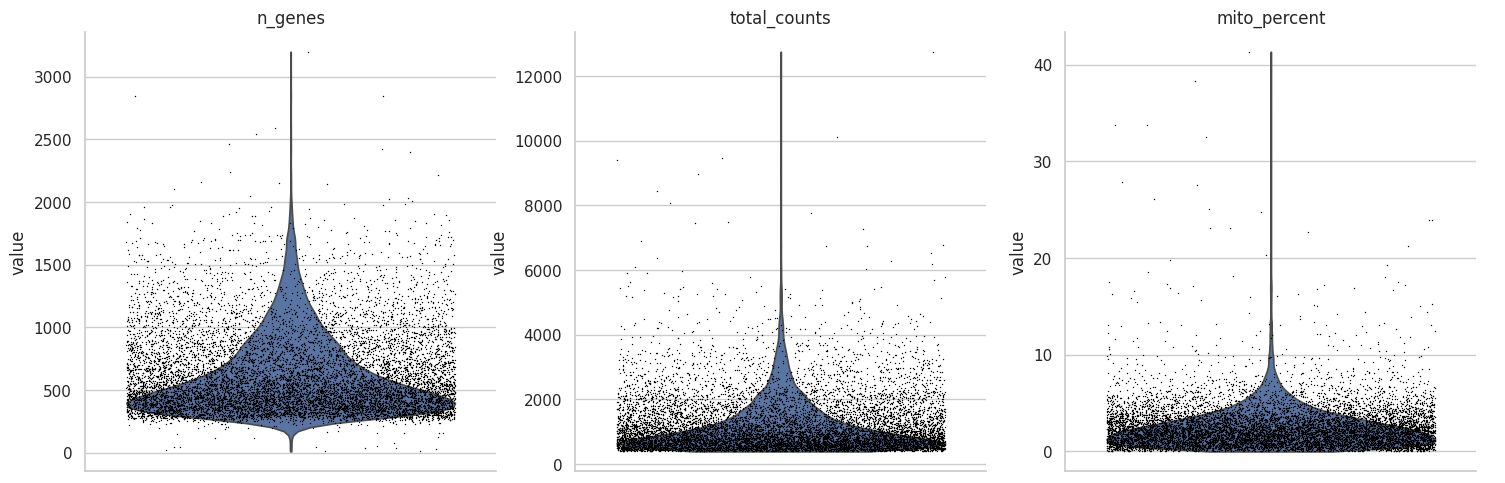

In [13]:
# Set up the plot style
sns.set(style="whitegrid")

# Plot the distribution of QC metrics for GSE142541 (Control dataset)
sc.pl.violin(
    adata_ctrl,
    ["n_genes", "total_counts", "mito_percent"],
    jitter=0.4,
    multi_panel=True,
)

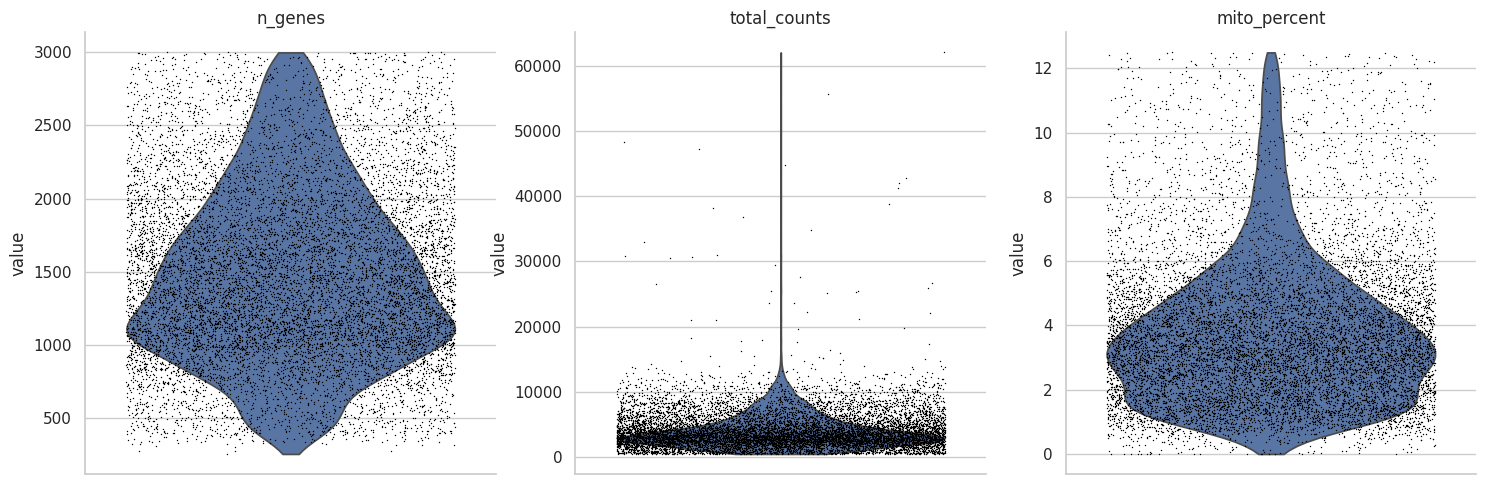

In [14]:
# Plot the distribution of QC metrics for GSE180498 (Diseased dataset)
sc.pl.violin(
    adata_diseased,
    ["n_genes", "total_counts", "mito_percent"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:
# # Using Scanpy functions
# # mitochondrial genes, "MT-" for human, "Mt-" for mouse
# adata_ctrl.var["mt"] = adata_ctrl.var_names.str.startswith("mt-")
# # ribosomal genes
# adata_ctrl.var["ribo"] = adata_ctrl.var_names.str.startswith(("RPS", "RPL"))
# # hemoglobin genes
# adata_ctrl.var["hb"] = adata_ctrl.var_names.str.contains("^HB[^(P)]")

# sc.pp.calculate_qc_metrics(
#     adata_ctrl, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
# )

# sc.pl.violin(
#     adata_ctrl,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

In [ ]:
# # Using Scanpy functions
# # mitochondrial genes, "MT-" for human, "Mt-" for mouse
# adata_diseased.var["mt"] = adata_diseased.var_names.str.startswith("mt-")
# # ribosomal genes
# adata_diseased.var["ribo"] = adata_diseased.var_names.str.startswith(("RPS", "RPL"))
# # hemoglobin genes
# adata_diseased.var["hb"] = adata_diseased.var_names.str.contains("^HB[^(P)]")

# sc.pp.calculate_qc_metrics(
#     adata_diseased, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
# )

# sc.pl.violin(
#     adata_diseased,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

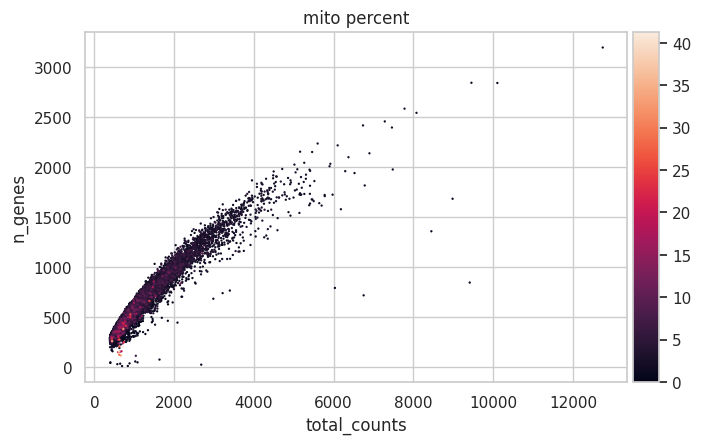

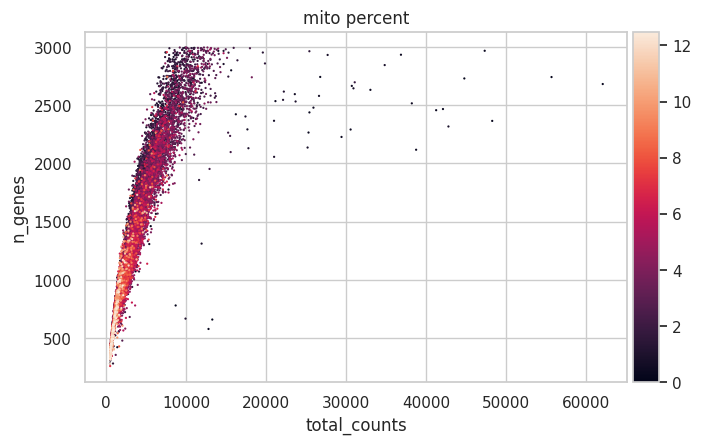

In [15]:
# Inspecting scatter plots by joining all QC metrics
sc.pl.scatter(adata_ctrl, "total_counts", "n_genes", color="mito_percent")
sc.pl.scatter(adata_diseased, "total_counts", "n_genes", color="mito_percent")

## Data filtration

In [77]:
# sc.pp.filter_cells(adata_ctrl, min_genes=100)
# sc.pp.filter_genes(adata_ctrl, min_cells=3)

In [78]:
# sc.pp.filter_cells(adata_diseased, min_genes=100)
# sc.pp.filter_genes(adata_diseased, min_cells=3)

In [16]:
# GSE142541 (Control dataset filtering)
adata_ctrl = adata_ctrl[adata_ctrl.obs['n_genes'] > 200]  # Keep cells with >200 genes
adata_ctrl = adata_ctrl[adata_ctrl.obs['mito_percent'] < 15]  # Keep cells with <15% mitochondrial genes

# GSE180498 (Diseased dataset filtering)
adata_diseased = adata_diseased[adata_diseased.obs['n_genes'] > 200]  # Keep cells with >200 genes
adata_diseased = adata_diseased[adata_diseased.obs['mito_percent'] < 15]  # Keep cells with <15% mitochondrial genes

In [ ]:
# Save filtered AnnData objects
# ctrl_data.write('/content/GSE142541_mouse_filtered.h5ad')
# diseased_data.write('/content/GSE180498_gw_filtered.h5ad')

## Doublet Finding

In [17]:
sc.pp.scrublet(adata_ctrl, batch_key="sample")
sc.pp.scrublet(adata_diseased, batch_key="sample")

In [18]:
print(adata_ctrl.obs.head())

                   sample cohort  total_counts  n_genes  mito_percent  \
AAACCTGGTAAAGTCA-1    SC1     SC           556      357      1.258993   
AAACCTGGTCCCTACT-1    SC1     SC           739      438      1.082544   
AAACCTGTCCTCCTAG-1    SC1     SC           695      307      1.870504   
AAAGATGAGCAATATG-1    SC1     SC           436      282      0.917431   
AAAGATGAGTTCGCAT-1    SC1     SC           622      376      1.768489   

                    doublet_score  predicted_doublet  
AAACCTGGTAAAGTCA-1       0.048679              False  
AAACCTGGTCCCTACT-1       0.035755              False  
AAACCTGTCCTCCTAG-1       0.019776              False  
AAAGATGAGCAATATG-1       0.035755              False  
AAAGATGAGTTCGCAT-1       0.048679              False  


In [19]:
print(adata_diseased.obs.head())

                             sample   cohort  total_counts  n_genes  \
R1_AAACCCAAGTCGCGAA-1  NOD.GW_SN_S1  NODAIRE          3164     1291   
R1_AAACCCACAAGTCCCG-1  NOD.GW_SN_S1  NODAIRE          5764     1831   
R1_AAACCCACATCTTTCA-1  NOD.GW_SN_S1  NODAIRE          7276     2105   
R1_AAACCCACATGAAGGC-1  NOD.GW_SN_S1  NODAIRE          5247     1645   
R1_AAACCCATCCGAGTGC-1  NOD.GW_SN_S1  NODAIRE          2985     1058   

                       mito_percent  doublet_score  predicted_doublet  
R1_AAACCCAAGTCGCGAA-1      3.634640       0.044444              False  
R1_AAACCCACAAGTCCCG-1      4.233171       0.051216              False  
R1_AAACCCACATCTTTCA-1      6.047279       0.041480              False  
R1_AAACCCACATGAAGGC-1      8.919383       0.018088              False  
R1_AAACCCATCCGAGTGC-1      5.192630       0.044444              False  
